In [1]:
import pandas as pd
import numpy as np

from src.models import CapitalManager, DaoParams
from src.simulation import AllocationSimulator

In [2]:
dao_params = DaoParams(
    alpha=0.6,
    beta=0.3,
    premium=0.02,
    min_bond=50000,
    penalty=0.01,
    epoch_length_hours=24*28,
    auction_length=-1,
    ema_window_risk_free=24*7,
    ema_window_reputation=30*24,
    slash_percent=0.01
)

In [3]:
data = pd.read_csv(
    'data/into_the_block_data_2024.csv',
    parse_dates=['DateTime'],
    index_col='DateTime'
).drop(columns=["Borrow APY", "Supply APY"]).rename(
    columns={
        'Net APY': 'net_apy',
        'Staking APY': 'staking_apy'
    }
)

# assuming a 10x leverage on the data, we simply take 
# the risk free rate (stETH base rate) as:
data['staking_apy'] = data['staking_apy'] / 10
data.rename(columns={'staking_apy': 'risk_free_rate'}, inplace=True)

# the risk free rate goes through an exponential moving average (7-D)
data["ema_riskfree"] = data["risk_free_rate"].ewm(
    span=7*24,  # 7 days * 24 hours
    adjust=False  # Use traditional EMA calculation
).mean()

data.drop(columns=['risk_free_rate'], inplace=True)
data

,net_apy,ema_riskfree
DateTime,,
2024-01-25 17:00:00,0.095773,0.025986
2024-01-25 18:00:00,0.094889,0.025986
2024-01-25 19:00:00,0.094905,0.025987
2024-01-25 20:00:00,0.094896,0.025987
2024-01-25 21:00:00,0.095693,0.025987
...,...,...
2025-01-22 11:00:00,0.105806,0.024897
2025-01-22 12:00:00,0.085278,0.024896
2025-01-22 13:00:00,0.066021,0.024871


In [4]:
managers = [
    CapitalManager(
        manager_id=f"CM_{i+1}",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=np.random.uniform(0.4, 0.9),
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    ) for i in range(5)
]

In [5]:
simulator = AllocationSimulator(
    data=data,
    initial_managers=managers,
    dao_params=dao_params,
    initial_capital=10_000_000,
    strategy_liq_buffer=0.11,
)

In [6]:
print("Starting simulation...")
results = simulator.run_simulation()

# Analyze and display results
print("Simulation complete. Results summary:")
print(f"Total epochs simulated: {len(results)}")
print(f"Final total capital: {results.iloc[-1]['total_capital']:,.2f}")

Starting simulation...
$$$$$$$$$$$
epoch ID: 0
----
manager CM_1 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.0882011762126412 and realised 0.0878136201865266
manager's absolute profits in epoch: 13472.774603960244
manager scored 0.005269429799749808 and was allocated 1520900.222610188
reputation score: 0.39643799629532794
----
manager CM_2 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.09117984246415836 and realised 0.09345340826384989
manager's absolute profits in epoch: 14338.057158289299
manager scored 0.005611029000343077 and was allocated 1619495.0079986246
reputation score: 0.3966452647800318
----
manager CM_3 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.09202392827382853 and realised 0.09879980576160909
manager's absolute profits in epoch: 15158.326363424956
manager scored 0.005940038542530379 and was allocated 1714456.076837098
reputation score: 0.3968448943726767
----
manage

In [7]:
plot_df = results.copy()
        
# Unpack dictionary columns
for col in ['allocations', 'scores', 'realized_yields']:
    expanded = plot_df[col].apply(pd.Series)
    expanded.columns = [f'{col}_{cid}' for cid in expanded.columns]
    plot_df = pd.concat([plot_df, expanded], axis=1)
    
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,allocations,scores,realized_yields,allocations_CM_1,allocations_CM_2,allocations_CM_3,...,scores_CM_1,scores_CM_2,scores_CM_3,scores_CM_4,scores_CM_5,realized_yields_CM_1,realized_yields_CM_2,realized_yields_CM_3,realized_yields_CM_4,realized_yields_CM_5
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.007020e+07,0.025836,0.045836,"{'CM_1': 1520900.222610188, 'CM_2': 1619495.00...","{'CM_1': 0.005269429799749808, 'CM_2': 0.00561...","{'CM_1': 0.0878136201865266, 'CM_2': 0.0934534...",1.520900e+06,1.619495e+06,1.714456e+06,...,5.269430e-03,5.611029e-03,5.940039e-03,5.135187e-03,1.293433e-02,0.087814,0.093453,0.098800,0.085518,0.091998
2024-02-22 00:00:00,1,1.014551e+07,0.026683,0.046683,"{'CM_1': 1967385.376271188, 'CM_2': 1997670.05...","{'CM_1': 0.00226353654172086, 'CM_2': 0.002298...","{'CM_1': 0.09508945611263604, 'CM_2': 0.096558...",1.967385e+06,1.997670e+06,2.185649e+06,...,2.263537e-03,2.298380e-03,2.514656e-03,2.284186e-03,2.311959e-03,0.095089,0.096558,0.105326,0.096020,0.095833
2024-03-21 00:00:00,2,1.021876e+07,0.026750,0.046750,"{'CM_1': 1881213.0625852644, 'CM_2': 2627302.4...","{'CM_1': 0.000886940347890936, 'CM_2': 0.00123...","{'CM_1': 0.0939365897630515, 'CM_2': 0.0932143...",1.881213e+06,2.627302e+06,1.847148e+06,...,8.869403e-04,1.238701e-03,8.708796e-04,8.765358e-04,9.448079e-04,0.093937,0.093214,0.092073,0.092782,0.098731
2024-04-18 00:00:00,3,1.027902e+07,0.022280,0.042280,"{'CM_1': 2874614.862549519, 'CM_2': 1850848.56...","{'CM_1': 0.0004407326875340557, 'CM_2': 0.0002...","{'CM_1': 0.0832354053302931, 'CM_2': 0.0754941...",2.874615e+06,1.850849e+06,1.877756e+06,...,4.407327e-04,2.837700e-04,2.878955e-04,2.827296e-04,2.808397e-04,0.083235,0.075494,0.076768,0.075544,0.074023
2024-05-16 00:00:00,4,1.034612e+07,0.024939,0.044939,"{'CM_1': 1989026.5369599264, 'CM_2': 2084831.3...","{'CM_1': 0.0001223734160891571, 'CM_2': 0.0001...","{'CM_1': 0.08214062763980641, 'CM_2': 0.086056...",1.989027e+06,2.084831e+06,2.033027e+06,...,1.223734e-04,1.282677e-04,1.250805e-04,1.270563e-04,1.337596e-04,0.082141,0.086057,0.084226,0.085655,0.089112
2024-06-13 00:00:00,5,1.038753e+07,0.023164,0.043164,"{'CM_1': 1502962.8671142969, 'CM_2': 1539627.5...","{'CM_1': 2.989289908348498e-05, 'CM_2': 3.0622...","{'CM_1': 0.05064224090329406, 'CM_2': 0.051902...",1.502963e+06,1.539628e+06,1.833883e+06,...,2.989290e-05,3.062213e-05,3.647468e-05,3.141715e-05,7.819398e-05,0.050642,0.051902,0.051202,0.053483,0.053500
2024-07-11 00:00:00,6,1.043243e+07,0.028176,0.048176,"{'CM_1': 2093999.442580645, 'CM_2': 2087113.55...","{'CM_1': 1.3266216884119069e-05, 'CM_2': 1.322...","{'CM_1': 0.0568881148107907, 'CM_2': 0.0566905...",2.093999e+06,2.087114e+06,2.025216e+06,...,1.326622e-05,1.322259e-05,1.283045e-05,1.357009e-05,1.320372e-05,0.056888,0.056691,0.055116,0.058386,0.055748
2024-08-08 00:00:00,7,1.047360e+07,0.022320,0.042320,"{'CM_1': 2025637.2994862075, 'CM_2': 2200227.8...","{'CM_1': 4.593904045122273e-06, 'CM_2': 4.9898...","{'CM_1': 0.04986471810927095, 'CM_2': 0.054132...",2.025637e+06,2.200228e+06,2.098698e+06,...,4.593904e-06,4.989855e-06,4.759598e-06,4.814684e-06,4.594825e-06,0.049865,0.054133,0.051709,0.052425,0.049059
2024-09-05 00:00:00,8,1.052162e+07,0.023903,0.043903,"{'CM_1': 2081060.2477892262, 'CM_2': 2106003.4...","{'CM_1': 2.1847740916623132e-06, 'CM_2': 2.210...","{'CM_1': 0.06004182202007394, 'CM_2': 0.060673...",2.081060e+06,2.106003e+06,2.079485e+06,...,2.184774e-06,2.210960e-06,2.183121e-06,2.315325e-06,2.151807e-06,0.060042,0.060674,0.060024,0.059877,0.058163


In [8]:
plot_df.dropna(inplace=True)
plot_df.drop(columns=["allocations", "scores", "realized_yields"], inplace=True)
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,allocations_CM_1,allocations_CM_2,allocations_CM_3,allocations_CM_4,allocations_CM_5,scores_CM_1,scores_CM_2,scores_CM_3,scores_CM_4,scores_CM_5,realized_yields_CM_1,realized_yields_CM_2,realized_yields_CM_3,realized_yields_CM_4,realized_yields_CM_5
timestamp,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.007020e+07,0.025836,0.045836,1.520900e+06,1.619495e+06,1.714456e+06,1.482154e+06,3.733199e+06,5.269430e-03,5.611029e-03,5.940039e-03,5.135187e-03,1.293433e-02,0.087814,0.093453,0.098800,0.085518,0.091998
2024-02-22 00:00:00,1,1.014551e+07,0.026683,0.046683,1.967385e+06,1.997670e+06,2.185649e+06,1.985333e+06,2.009472e+06,2.263537e-03,2.298380e-03,2.514656e-03,2.284186e-03,2.311959e-03,0.095089,0.096558,0.105326,0.096020,0.095833
2024-03-21 00:00:00,2,1.021876e+07,0.026750,0.046750,1.881213e+06,2.627302e+06,1.847148e+06,1.859145e+06,2.003951e+06,8.869403e-04,1.238701e-03,8.708796e-04,8.765358e-04,9.448079e-04,0.093937,0.093214,0.092073,0.092782,0.098731
2024-04-18 00:00:00,3,1.027902e+07,0.022280,0.042280,2.874615e+06,1.850849e+06,1.877756e+06,1.844063e+06,1.831736e+06,4.407327e-04,2.837700e-04,2.878955e-04,2.827296e-04,2.808397e-04,0.083235,0.075494,0.076768,0.075544,0.074023
2024-05-16 00:00:00,4,1.034612e+07,0.024939,0.044939,1.989027e+06,2.084831e+06,2.033027e+06,2.065141e+06,2.174095e+06,1.223734e-04,1.282677e-04,1.250805e-04,1.270563e-04,1.337596e-04,0.082141,0.086057,0.084226,0.085655,0.089112
2024-06-13 00:00:00,5,1.038753e+07,0.023164,0.043164,1.502963e+06,1.539628e+06,1.833883e+06,1.579600e+06,3.931457e+06,2.989290e-05,3.062213e-05,3.647468e-05,3.141715e-05,7.819398e-05,0.050642,0.051902,0.051202,0.053483,0.053500
2024-07-11 00:00:00,6,1.043243e+07,0.028176,0.048176,2.093999e+06,2.087114e+06,2.025216e+06,2.141964e+06,2.084135e+06,1.326622e-05,1.322259e-05,1.283045e-05,1.357009e-05,1.320372e-05,0.056888,0.056691,0.055116,0.058386,0.055748
2024-08-08 00:00:00,7,1.047360e+07,0.022320,0.042320,2.025637e+06,2.200228e+06,2.098698e+06,2.122988e+06,2.026044e+06,4.593904e-06,4.989855e-06,4.759598e-06,4.814684e-06,4.594825e-06,0.049865,0.054133,0.051709,0.052425,0.049059
2024-09-05 00:00:00,8,1.052162e+07,0.023903,0.043903,2.081060e+06,2.106003e+06,2.079485e+06,2.205414e+06,2.049658e+06,2.184774e-06,2.210960e-06,2.183121e-06,2.315325e-06,2.151807e-06,0.060042,0.060674,0.060024,0.059877,0.058163


<Axes: xlabel='timestamp'>

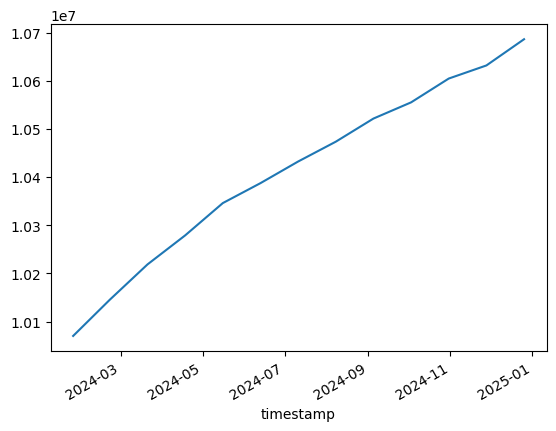

In [9]:
plot_df.dropna().total_capital.plot()

In [10]:
manager_ids = [f"allocations_CM_{i}" for i in range(1, 6)]

<Axes: xlabel='timestamp'>

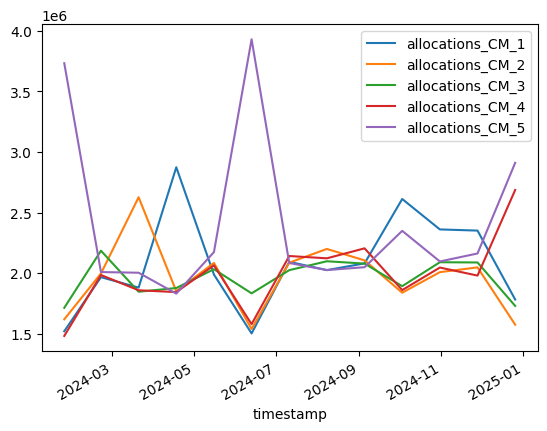

In [11]:
plot_df[manager_ids].plot()

In [12]:
total=0
for mngr in managers:
    print(mngr.manager_id, mngr.strategy_risk, mngr.bond_amount, '\t|', mngr.allocated_capital/1e6)
    total+= mngr.allocated_capital
total/1e6

CM_1 0.8207065508339006 98010.0 	| 1.782875871176192
CM_2 0.847953939862433 98010.0 	| 1.5754535328526194
CM_3 0.7751247229793522 98010.0 	| 1.7300601542770313
CM_4 0.7219724299420511 98010.0 	| 2.686951952179944
CM_5 0.5408460645058086 98010.0 	| 2.9110602592160317


np.float64(10.686401769701819)